# Use Topic-Specific PageRank to Perform Collaborative Filtering

First we'll need to import the relevant packages

In [44]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy import sparse
from fast_pagerank import pagerank_power
import matplotlib.pyplot as plt
np.random.seed(0)

Now let's load in the reviews data and produce our bipartite ratings/reviewers graph

In [37]:
ratings = pd.read_csv('../raw/ratings.csv')

# Let's enumerate the elements so we can use them as indices
users = ratings['userId'].unique()
users = pd.DataFrame(users, columns=['userId'])
users['user_index'] = users.index

# Note we need to add the number of users to the movie index so we don't have overlapping indices
# Since the graph is bipartite but the package doesn't support this, we need to implement it ourselves
movies = pd.read_csv('../raw/movies.csv')
movies['movie_index'] = movies.index + users.shape[0]

# Count the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()
ratings_per_movie = pd.DataFrame(ratings_per_movie, columns=['num_ratings'])
movies = pd.merge(movies, ratings_per_movie, on='movieId')

# Get the TMDB IDs for each movie
links = pd.read_csv('../raw/links.csv')
movies = pd.merge(movies, links, on='movieId')

# Merge the indices back into the ratings dataframe
ratings = pd.merge(ratings, users, on='userId')
ratings = pd.merge(ratings, movies, on='movieId')

MIN_MOVIE_INDEX = np.min(movies['movie_index'])
MAX_INDEX = np.max(movies['movie_index']) + 1

We'll now need to produce the adjacency matrix

In [4]:
# Now we can create the user-movie matrix
# Note we concat user and movie indices since the matrix is symmetric
user_movie = sparse.csr_matrix(
    (
        pd.concat([ratings['rating'], ratings['rating']]), 
        (pd.concat([ratings['user_index'], ratings['movie_index']]), pd.concat([ratings['movie_index'], ratings['user_index']]))
    ), 
    shape = (MAX_INDEX, MAX_INDEX)
)

In order to filter out movies just "being popular," we'll use the Topic-Specific PageRank algorithm to rank the movies. This algorithm is a variant of the PageRank algorithm that allows us to rank the nodes in a graph based on a specific topic. In this case, the topic is the movies that the user has rated. We'll also want to normalize a movie's TSPR by their "normal" PR.

In [15]:
unpersonalized_pr = pagerank_power(user_movie, p=0.85)

Let's compute the TSPR for a specific movie

In [47]:
def compute_tspr(index, adjacency, unpersonalized_pr):
    personalize = np.zeros(MAX_INDEX)
    personalize[index] = 1
    pr = pagerank_power(adjacency, p=0.85, personalize=personalize)
    return pr / unpersonalized_pr

relative_pr = compute_tspr(162541, user_movie, unpersonalized_pr) # Toy Story

Get list of indices with highest pagerank

In [36]:
# Get the top 10 indices
top_indices = np.argsort(relative_pr[MIN_MOVIE_INDEX:])[::-1][:10]
top_df = pd.DataFrame(top_indices + MIN_MOVIE_INDEX, columns=['movie_index'])
top_df = pd.merge(top_df, movies, on='movie_index')

                                             title  \
0                                 Toy Story (1995)   
1  Homeward Bound II: Lost in San Francisco (1996)   
2                                 Mr. Wrong (1996)   
3                                Sgt. Bilko (1996)   
4                                   Flipper (1996)   
5                   All Dogs Go to Heaven 2 (1996)   
6                     Up Close and Personal (1996)   
7              Adventures of Pinocchio, The (1996)   
8                                Juror, The (1996)   
9                        Executive Decision (1996)   

                                              genres  
0        Adventure|Animation|Children|Comedy|Fantasy  
1                                 Adventure|Children  
2                                             Comedy  
3                                             Comedy  
4                                 Adventure|Children  
5  Adventure|Animation|Children|Fantasy|Musical|R...  
6                   

Now that we think this "works," let's get the set of movies that we also have TMDB data for

In [43]:
# Load in the TMDB data
tmdb = pd.read_parquet('../../tmdb/embeddings/movie_descriptions.parquet')
tmdb = tmdb['tmdb_id'].unique()
tmdb = pd.DataFrame(tmdb, columns=['tmdbId'])

# Get the set of TMDB IDs present in both datasets
relevant_movies = pd.merge(movies, tmdb, on='tmdbId', how='inner')

Let's pick a sample of 100 to start

In [99]:
# Pick 100 random movies from the relevant set
RATING_THRESHOLD = 10000
popular_movies = relevant_movies[relevant_movies['num_ratings'] > RATING_THRESHOLD]

In [100]:
# For each movie, compute the topic-specific pagerank
indices = popular_movies['movie_index'].values
tsprs = np.array([compute_tspr(index, user_movie, unpersonalized_pr) for index in indices])

KeyboardInterrupt: 

In [76]:
# Convert TSPRs to a DataFrame
tspr_df = pd.DataFrame(tsprs, columns=[f'tspr_{i}' for i in range(len(tsprs[0]))])
tspr_df['movie_index_a'] = indices

# Reshape long
tspr_df = tspr_df.melt(id_vars='movie_index_a', var_name='movie_index_b', value_name='tspr')
tspr_df['movie_index_b'] = tspr_df['movie_index_b'].str.replace('tspr_', '').astype(int)

# Drop if movie not in indices
tspr_df = tspr_df[tspr_df['movie_index_b'].isin(indices)]

# Merge the TMDB IDs back on given the indices
tspr_df = pd.merge(tspr_df, movies, left_on='movie_index_a', right_on='movie_index', how='left')
tspr_df = tspr_df.rename(columns={'tmdbId': 'tmdb_id_1'})
tspr_df = pd.merge(tspr_df, movies, left_on='movie_index_b', right_on='movie_index', how='left')
tspr_df = tspr_df.rename(columns={'tmdbId': 'tmdb_id_2'})

In [77]:
# Get the text distance pairings
# Note these were originally only the triangle, so we need to add the other half
text_distances = pd.read_parquet('../../movie_text_distances/output/movie_text_distances.parquet')
text_distances['text_similarity'] = 1 - text_distances['distance']
text_distances_copy = text_distances.copy()
text_distances_copy['temp'] = text_distances_copy['tmdb_id_1']
text_distances_copy['tmdb_id_1'] = text_distances_copy['tmdb_id_2']
text_distances_copy['tmdb_id_2'] = text_distances_copy['temp']
text_distances_copy = text_distances_copy.drop(columns=['temp'])
text_distances = pd.concat([text_distances, text_distances_copy], axis=0)

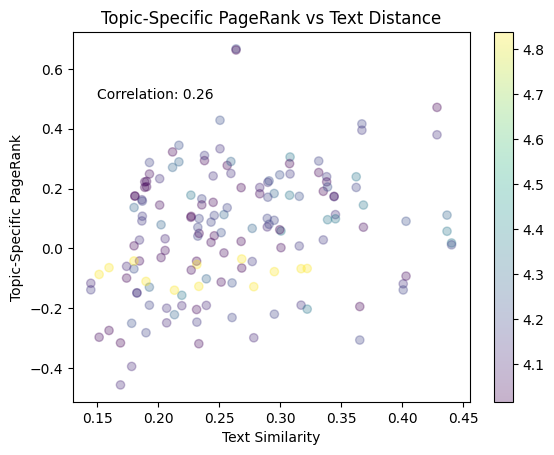

In [98]:
# Merge the two sets of distances
merged_df = pd.merge(tspr_df, text_distances, on=['tmdb_id_1', 'tmdb_id_2'], how='left')

# Drop if num_ratings_x num_ratings_y is too small
# Otherwise collaborative filtering generally doesn't work well
merged_df = merged_df[(merged_df['num_ratings_x'] > 10000) & (merged_df['num_ratings_y'] > 10000)]

# Drop if tmdb_id_1 == tmdb_id_2
merged_df = merged_df[merged_df['tmdb_id_1'] != merged_df['tmdb_id_2']]

correlation = merged_df['text_similarity'].corr(np.log(merged_df['tspr']))

# Plot the two distances
plt.scatter(
    merged_df['text_similarity'], 
    np.log(merged_df['tspr']), 
    alpha = 0.3,
    c = np.log10(merged_df['num_ratings_x']),
)

# Add legend for color
plt.colorbar()

plt.ylabel('Topic-Specific PageRank')
plt.xlabel('Text Similarity')
plt.title('Topic-Specific PageRank vs Text Distance')

# Add the correlation to the plot
plt.text(0.15, 0.5, f'Correlation: {correlation:.2f}')

plt.show()